# Evaluating Classifiers

To illustrate various approaches, we'll use UCI's [Pima Indian Diabetes](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) dataset.

For the target variable, 1=diabetes, 0=no diabetes

In [7]:
import pandas as pd
data = pd.read_csv('data/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Can we predict the diabetes status of a patient given their health measurements?**

In [21]:
# Define X and y
X = data[['Pregnancies', 'Insulin', 'BMI', 'Age']]
y = data[['Outcome']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [26]:
# train model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train, y_train.values.ravel())

# make predictions
y_preds = model.predict(X_test)

# calculate accuracy
from sklearn.metrics import accuracy_score
print(f'Classification accuracy is: {accuracy_score(y_test, y_preds)}')

Classification accuracy is: 0.671875


Now we calculate the **Null accuracy**: the accuracy that could be achieved by always predicting the most frequent class

In [31]:
# examine the distribution of the testing set
y_test['Outcome'].value_counts()

0    127
1     65
Name: Outcome, dtype: int64

In [34]:
# calculate percentage of ones
# since this column is binary, we can calculate the mean
print(f'% of 1s: {y_test.mean()}')
print(f'% of 0s: {1 - y_test.mean()}')

# for multi-class:
# y_test['Outcome'].value_counts.head(1) / len(y_test)

% of 1s: Outcome    0.338542
dtype: float64
% of 0s: Outcome    0.661458
dtype: float64


This means that a dumb model that only predicts 0 would be right 66% of the time. Seeing as our model shows 67% accuracy, classification accuracy is not a great metric as it's close to a dumb model.

There are better approaches:

## Confusion Matrix

Text(33,0.5,'Actual')

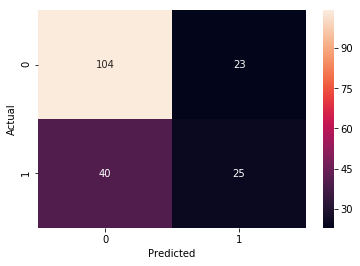

In [47]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

cm = confusion_matrix(y_test, y_preds)
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1])

sns.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

**Terminology**
* **True Positives (TP)**: we *correctly* predicted that they *do* have diabetes (25)
* **True Negatives (TN)**: we *correctly* predicted that they *don't* have diabetes (104)
* **False Positives (FP)**: we *incorrectly* predicted that they *do* have diabetes (23) (Type I error)
* **False Negatives (FN)**: we *incorrectly* predicted that they *don't* have diabetes (40) (Type II error)

We can use these variables to calculate a few different metrics:

In [48]:
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

**Classification Accuracy**: Overall, how often is the classifier correct?

In [56]:
print((TP + TN) / float(TP + TN + FP + FN))

0.671875


**Classification Error**: Overall, how often is the classifier incorrect?

In [58]:
print((FP + FN) / float(TP + TN + FP + FN))

0.328125


**Sensitivity**: When the actual value is positive, how often is the prediction correct?

How *sensitive* is the classifier to detecting positive instances? This is something we want to maximize.

Also known as the "True Positive Rate" or "Recall".

In [60]:
from sklearn.metrics import recall_score

# True Positives divided by all positives
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(recall_score(y_test, y_preds))

0.38461538461538464
0.38461538461538464


**Specificity:** When the actual value is negative, how often is the prediction correct?

How *specific* is the classifier in predicting positive instances? Something we want to maximize.

In [61]:
# TN / All negative
specificity = TN / (TN + FP)

print(specificity)

0.8188976377952756


So, our classifier is highly specific but not sensitive

**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?

In [62]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.18110236220472442
0.18110236220472442


**Precision:** When a positive value is predicted, how often is the prediction correct? I.e. - how "precise" is the classifier when predicting positive instances?

In [63]:
precision = TP / float(TP + FP)

print(precision)
from sklearn.metrics import precision_score
print(precision_score(y_test, y_preds))

0.5208333333333334
0.5208333333333334


**F1 Score:** a measure of a test's accuracy - calculated using the harmonic mean of a test's precision and recall. Super useful.

In [68]:
from sklearn.metrics import f1_score

f1 = (sensitivity + precision) / 2

print(f1)
print(f1_score(y_test, y_preds))

0.45272435897435903
0.4424778761061947


## So how do we decide which to use?

Depends on your business objective.
* Decide whether FP or FN are more important to reduce

Examples
* **Spam filter** (positive class is "spam)
    * Optimize for **precision or specificity** (FP as variable)
    * Because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the filter)
* **Fradulent transaction detector** (positive class is "fraud")
    * Optimize for sensitivity (FN as variable)
    * Because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

## Adjusting the classification threshold
We can use some of these metrics to adjust our model. Here's a walkthrough of a probabalistic approach:

In [97]:
#  predicted responses
outcomes = pd.DataFrame(model.predict(X_test),
                        columns=['Outcome'])

# the predicted probabilities of class membership
probas = pd.DataFrame(model.predict_proba(X_test),
                      columns=['Prob_Class0', 'Prob_Class1'])

probas = probas.join(outcomes)
probas.head()

,Prob_Class0,Prob_Class1,Outcome
0,0.583959,0.416041,0
1,0.732468,0.267532,0
2,0.436772,0.563228,1
3,0.555025,0.444975,0
4,0.489777,0.510223,1


We can rank these observations by probability of diabetes (higher probability the better)

We have a 0.5 classification threshold (Class 1 is predicted if probability > 0.5, Class 0 if probability < 0.5)

Text(0,0.5,'Frequency')

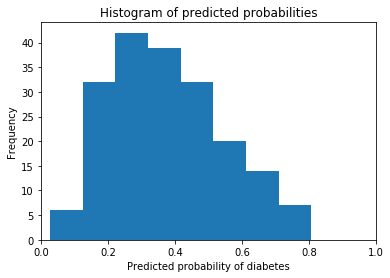

In [98]:
plt.hist(probas['Prob_Class1'], bins=8)

plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

We can see from the 3rd bin that > 40% of the observations have probability of 0.3 to 0.4. 

Many less have probability > 0.5 - this is below the base threshold of 0.5. Most would be predicted "no diabetes in this case.

**Solution**: **Decrease the threshold** for predicting diabetes
* **Increase the sensitivity** of the classifier
    * This would increase the number of TPs, making the model more sensitive to positive instances.
* Example of a metal detector: Threshold to set off alarm for large objects but not tiny objects
    * YES: metal, NO: no metal
    * We lower the threshold amount of metal to set it off, making it more sensitive to metal, predicting YES more often

In [115]:
# predict diabetes if the predicted probability is greater than 0.4
from sklearn.preprocessing import binarize

# return 1 for all values above 0.3 and 0 otherwise
import numpy as np
prob_zero = np.array(probas['Prob_Class0']).reshape(-1, 1)
new_y_preds = binarize(prob_zero, 0.4)

In [118]:
# print old confusion matrix
print(cm)

# print new confusion matrix
print(confusion_matrix(y_test, new_y_preds))

[[104  23]
 [ 40  25]]
[[  9 118]
 [ 13  52]]


In [122]:
# sensitivity has increased (used to be 0.38)
print(52 / float(52 + 13))

0.8


In [123]:
# specificity has decreased (used to be 0.81)
print(9 / float(9 + 118))

0.07086614173228346


## Receiver Operating Characteristic (ROC) Curve

Wouldn't it be great if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?

Well, we can! **By plotting the ROC curve**

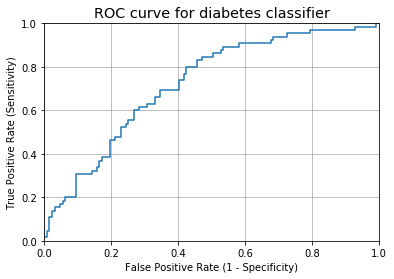

In [124]:
from sklearn.metrics import roc_curve

# store the predicted probabilities for class 1
y_pred_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

We can use this to help us **choose a threshold** that balances specificity and sensitivity in a way that makes sense for our specific context.

We can't actually see the thresholds used to generate the curve on the ROC itself, but we can calculate it:

In [125]:
# define a function that accepts a threshold 
# and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print(f'Sensitivity: {tpr[thresholds > threshold][-1]}')
    print(f'Specificity: {1 - fpr[thresholds > threshold][-1]}')

In [127]:
print('0.5 threshold')
evaluate_threshold(0.5)
print('\n0.3 threshold')
evaluate_threshold(0.3)

0.5 threshold
Sensitivity: 0.38461538461538464
Specificity: 0.8267716535433071

0.3 threshold
Sensitivity: 0.8615384615384616
Specificity: 0.4724409448818898


### AUC
AUC is the **percentage** of the ROC plot that is **underneath the curve**:

In [128]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, y_pred_prob))

0.7208964264082374


AUC is useful as a single number summary of classifier performance - the higher the value the better the classifier

AUC represents **the likelihood that your classifier will assign a higher predicted probability to the positive observation**. AUC is useful even when there is high class imbalance (unlike classification accuracy)

### Summary
1. **Confusion matrix advantages:**
    * Allows you to create a variety of metrics
    * Useful for multi-class problems
2. **ROC/AUC advantages:**
    * Does not require you to set a classification threshold
    * Useful when there is high class imbalance
    
### Confusion Matrix Resources
* Videos: [Intuitive sensitivity and specificity](https://www.youtube.com/watch?v=U4_3fditnWg) (9 minutes) and [The tradeoff between sensitivity and specificity](https://www.youtube.com/watch?v=vtYDyGGeQyo) (13 minutes)
* Notebook: [How to calculate "expected value"](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb) from a confusion matrix by treating it as a cost-benefit matrix
* Graphic: How [classification threshold](https://media.amazonwebservices.com/blog/2015/ml_adjust_model_1.png) affects different evaluation metrics (from a [blog post](https://aws.amazon.com/blogs/aws/amazon-machine-learning-make-data-driven-decisions-at-scale/) about Amazon Machine Learning)

### ROC and AUC Resources
* Lesson notes: [ROC Curves](http://ebp.uga.edu/courses/Chapter%204%20-%20Diagnosis%20I/8%20-%20ROC%20curves.html)
* Video:[ROC Curves](https://www.youtube.com/watch?v=21Igj5Pr6u4)
* Paper: [An Introduction to ROC Analysis](http://people.inf.elte.hu/kiss/13dwhdm/roc.pdf)
* Usage Examples: [Comparing different feature sets](http://research.microsoft.com/pubs/205472/aisec10-leontjeva.pdf) for detecting fraudulent Skype users and [comparing different classifiers](http://www.cse.ust.hk/nevinZhangGroup/readings/yi/Bradley_PR97.pdf) on a number of popular datasets

Thanks to [Ritchie Ng](https://www.ritchieng.com/machine-learning-evaluate-classification-model/) for the lesson.